# Análise das empresas taiwanesas
[LINK](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?resource=download)

Os dados consistem em métricas financeiras de empresas listadas na Bolsa de Valores de Taiwan. O objetivo é usar essas métricas para prever a probabilidade de uma empresa falir em um futuro próximo.

[Exemplo no Scikit-Learn](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import lightgbm
from sklearn import (
    preprocessing,
    metrics,
    pipeline,
    model_selection,
    inspection
)
from scipy.cluster import hierarchy as sch

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(
    style="whitegrid",
    palette="colorblind",
    rc={"figure.figsize": (11.7, 8.27)}
)

/Users/fabiogavarinibaccarin/.local/share/virtualenvs/colinearidade-OMZFyDA9/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ferramentas

## Dados

In [2]:
df = pd.read_csv("data.csv")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [3]:
# renomeando para facilitar o código
NAMES = {
    c: "y" if c == "Bankrupt?" else f"x{i:02d}"
    for i, c in enumerate(df.columns)
}
NAMES

{'Bankrupt?': 'y',
 ' ROA(C) before interest and depreciation before interest': 'x01',
 ' ROA(A) before interest and % after tax': 'x02',
 ' ROA(B) before interest and depreciation after tax': 'x03',
 ' Operating Gross Margin': 'x04',
 ' Realized Sales Gross Margin': 'x05',
 ' Operating Profit Rate': 'x06',
 ' Pre-tax net Interest Rate': 'x07',
 ' After-tax net Interest Rate': 'x08',
 ' Non-industry income and expenditure/revenue': 'x09',
 ' Continuous interest rate (after tax)': 'x10',
 ' Operating Expense Rate': 'x11',
 ' Research and development expense rate': 'x12',
 ' Cash flow rate': 'x13',
 ' Interest-bearing debt interest rate': 'x14',
 ' Tax rate (A)': 'x15',
 ' Net Value Per Share (B)': 'x16',
 ' Net Value Per Share (A)': 'x17',
 ' Net Value Per Share (C)': 'x18',
 ' Persistent EPS in the Last Four Seasons': 'x19',
 ' Cash Flow Per Share': 'x20',
 ' Revenue Per Share (Yuan ¥)': 'x21',
 ' Operating Profit Per Share (Yuan ¥)': 'x22',
 ' Per Share Net profit before tax (Yuan ¥)'

In [4]:
NAMES_KEYS = list(NAMES.keys())
NAMES_VALS = list(NAMES.values())

def get_original_name(code):
    return NAMES_KEYS[NAMES_VALS.index(code)]

In [5]:
df = df.rename(columns=NAMES)
df.head(3)

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


## Análise exploratória

In [6]:
# nulos
df.isna().mean().to_frame().T.style.format("{:.2%}")

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [7]:
# testando que não tem absolutamente nenhum nulo
assert df.isna().sum().sum() == 0

In [8]:
# verificando que todas as variáveis são contínuas
df.nunique().to_frame().T.style.format("{:,}")

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95
0,2,"3,333","3,151","3,160","3,781","3,788","3,376","3,789","3,604","2,551","3,617","2,966","1,536","5,557","1,080","2,488","2,278","2,285","2,284","1,358","1,545","3,807","1,236","1,522","5,583","6,249","6,246","6,253","6,270","1,751","4,502","2,903","3,599","6,132","6,094","3,794","5,518","4,208","4,208","6,523","4,338","1,855","4,423","4,785","5,289",381,"1,593","5,451","2,397","2,451",741,"5,667","3,023","6,768","6,819","6,819","6,819","6,819","6,819","6,816","6,819","6,819","6,593","6,590","6,627","6,819","6,819","4,249","6,819","6,819","6,819","6,261","5,377","6,819","4,023","6,819","6,814","6,627","6,819","4,251","6,819","6,819","6,819","6,819","6,819",2,"6,819","6,818","6,819","6,816","6,819","6,819","6,240","6,240",1,"6,819"


In [9]:
print(get_original_name("x85"))
print(get_original_name("x94"))

 Liability-Assets Flag
 Net Income Flag


In [10]:
"x85 prevalence={:.2%}".format(df["x85"].mean())

'x85 prevalence=0.12%'

In [11]:
# removendo x85 e x94
df = df.drop(columns=["x85", "x94"])

# provando que todas as variáveis são contínuas
assert df.drop(columns="y").nunique().min() > 40

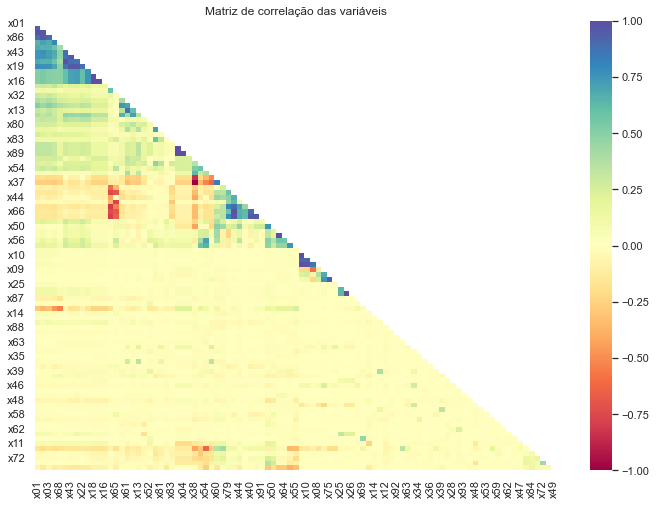

In [12]:
# correlação entre as variáveis
corr = df.drop(columns="y").corr()

# faz um clustering hierárquico, agrupando as variáveis mais correlacionadas
# fonte: https://wil.yegelwel.com/cluster-correlation-matrix/
pairwise_distances = sch.distance.pdist(corr)
linkage = sch.linkage(pairwise_distances, method="ward")
cluster_distance_threshold = pairwise_distances.max()/2
idx_to_cluster_array = sch.fcluster(
    linkage,
    cluster_distance_threshold,
    criterion="distance"
)
idx = np.argsort(idx_to_cluster_array)

sns.heatmap(
    corr.iloc[idx, :].T.iloc[idx, :],
    cmap="Spectral",
    mask=np.triu(np.ones(corr.shape)).astype(bool)
).set(title="Matriz de correlação das variáveis");

## Modelagem

In [13]:
X = df.drop(columns="y")
y = df["y"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5455, 93) (5455,)
(1364, 93) (1364,)


In [14]:
preprocessor = pipeline.make_pipeline(
    preprocessing.QuantileTransformer(
        output_distribution="normal",
        random_state=0
    ),
    preprocessing.MaxAbsScaler(),
)

### Ranking das variáveis

In [15]:
tmp = X.corrwith(y, method="spearman").abs().rename("corr")
RANKING = pd.concat([tmp, tmp.rank(ascending=False).rename("rank")], axis=1)
del tmp
RANKING.sort_values(by="rank").head().style.format({
    "corr": "{:.0%}", "rank": "{:.0f}"
})

,corr,rank
x19,24%,1
x86,23%,2
x43,23%,3
x23,23%,4
x68,23%,5


### Usando todas as variáveis

In [16]:
X_train_prep = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_prep = pd.DataFrame(
    preprocessor.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)
print(X_train_prep.shape, X_test_prep.shape, sep="\n")

(5455, 93)
(1364, 93)


In [17]:
lgbc_full = lightgbm.LGBMClassifier(random_state=0).fit(X_train_prep, y_train)

probs_full = pd.Series(
    lgbc_full.predict_proba(X_test_prep)[:, 1],
    index=X_test_prep.index,
    name="probs_full"
)
roc_full = metrics.roc_auc_score(y_test, probs_full)
f"ROC FULL={roc_full:.0%}"

'ROC FULL=95%'

In [18]:
shaps_full = pd.DataFrame(
    shap.TreeExplainer(lgbc_full).shap_values(X_test_prep)[0],
    index=X_test_prep.index,
    columns=X_test_prep.columns
)
shaps_full

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x84,x86,x87,x88,x89,x90,x91,x92,x93,x95
4488,0.019893,-0.056349,0.243815,0.000604,0.000346,-0.043367,0.007649,0.010631,-0.006283,0.087171,...,-0.003690,0.623432,0.003934,-0.006062,0.004800,-0.002318,-0.010379,0.019010,0.027838,-0.005362
2195,0.091583,0.024316,-0.106254,-0.005866,0.000168,0.014486,0.024749,-0.169701,0.202470,-0.128686,...,0.003359,-0.362278,-0.167755,0.024668,-0.003166,0.016849,-0.014415,0.020812,0.013427,0.011524
4150,0.002194,0.006820,-0.040825,0.001725,0.000295,0.006212,0.020516,-0.169584,0.061472,0.020824,...,0.018562,0.081310,0.051495,0.047478,0.003897,0.040910,-0.021239,0.024830,0.023089,-0.006993
1117,0.031239,0.006302,-0.007181,-0.000824,0.000370,0.009993,0.021782,-0.028704,0.113479,0.042170,...,-0.006499,-0.327593,0.061641,-0.033308,0.003549,0.020780,-0.014289,0.010324,0.035677,-0.014247
1179,-0.309518,0.023749,-0.361210,0.004277,0.000124,-0.018079,-0.007498,-0.135006,-0.469122,-0.776954,...,0.029690,-0.932577,-0.066309,0.004253,-0.007811,-0.267762,-0.024616,-0.091207,-0.024495,-0.028991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0.024484,-0.056656,0.210946,0.004081,0.000807,0.070875,-0.050451,-0.048419,0.108534,0.151161,...,0.015016,0.625726,0.022058,0.019484,0.005455,-0.040775,-0.006392,0.035820,0.025759,-0.036810
1893,0.038008,0.008437,-0.101039,0.021870,0.000300,0.010948,0.075094,-0.025736,-0.016682,0.024883,...,-0.000800,-0.311508,0.036992,0.051684,0.006773,0.013987,0.000569,0.045367,0.042289,-0.012397
5763,-0.057505,0.006659,-0.234667,0.003414,0.000300,-0.027605,-0.028690,-0.127478,-0.734469,-0.361354,...,-0.000195,-0.508643,0.040539,0.077665,-0.002368,0.017790,0.018442,-0.171158,-0.082986,-0.015136
4703,-0.040640,0.003857,-0.232369,0.000276,0.000284,0.012198,-0.008264,-0.177763,-0.185057,-0.325846,...,-0.009484,-0.381307,0.010486,-0.142712,-0.019153,0.030935,-0.054004,0.020259,0.050925,-0.024790


In [19]:
shaps_full = np.exp(shaps_full.abs().mean()).sub(1).mul(100)
shaps_full.sort_values(ascending=False)

x86    55.436527
x34    37.361914
x19    33.578168
x53    29.039226
x36    28.893006
         ...    
x37     0.923704
x22     0.675919
x05     0.122025
x77     0.000000
x78     0.000000
Length: 93, dtype: float64

In [20]:
(
    shaps_full.describe().iloc[1:]
    .rename("Impacto percentual no risco de falência")
    .to_frame()
    .style.format("{:.0f}%")
)

,Impacto percentual no risco de falência
mean,7%
std,9%
min,0%
25%,2%
50%,4%
75%,6%
max,55%


In [21]:
perm_importances = pd.Series(
    inspection.permutation_importance(
        lgbc_full,
        X_test_prep,
        y_test,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=0
    ).importances_mean,
    index=X_test_prep.columns,
    name="importance"
)

In [22]:
"Impacto absoluto máximo={:.2%}".format(perm_importances.abs().max())

'Impacto absoluto máximo=1.26%'

### Selecionando variáveis

In [23]:
def select_features_by_corr(X_train, y_train, cutoff=0.75, method="spearman"):
    features = X_train.columns.to_list()
    ranking = (
        X_train.corrwith(y_train, method=method)
        .abs()
        .rank(ascending=False)
    )
    
    corr = X_train.corr()
    np.fill_diagonal(corr.values, np.nan)
    redundant_pairs = []
    for i in corr:
        for j in corr:
            if abs(corr.at[i, j]) > cutoff:
                redundant_pairs.append((i, j))
    
    drop = list(set([
        x1 if ranking[x1] > ranking[x2] else x2
        for x1, x2 in redundant_pairs
    ]))
    
    keep = list(set(features) - set(drop))
    
    return keep

In [24]:
def check_corr(df, features, cutoff=0.75):
    x = df[features].corr()
    np.fill_diagonal(x.values, np.nan)
    assert x.abs().max().between(0, cutoff, inclusive="left").all()

In [25]:
keep = select_features_by_corr(X_train, y_train)
len(keep)

62

In [26]:
check_corr(X_train, keep)

In [27]:
X_train_prep_sel = X_train_prep.filter(keep)
X_test_prep_sel = X_test_prep.filter(keep)
print(X_train_prep_sel.shape, X_test_prep_sel.shape, sep="\n")

(5455, 62)
(1364, 62)


In [28]:
lgbc_sel = lightgbm.LGBMClassifier(random_state=0).fit(
    X_train_prep_sel,
    y_train
)

probs_sel = pd.Series(
    lgbc_sel.predict_proba(X_test_prep_sel)[:, 1],
    index=X_test_prep_sel.index,
    name="probs_sel"
)
roc_sel = metrics.roc_auc_score(y_test, probs_sel)
f"ROC SELECTED={roc_sel:.0%}"

'ROC SELECTED=95%'

In [29]:
shaps_sel = pd.DataFrame(
    shap.TreeExplainer(lgbc_sel).shap_values(X_test_prep_sel)[0],
    index=X_test_prep_sel.index,
    columns=X_test_prep_sel.columns
)
shaps_sel

,x88,x62,x51,x69,x58,x47,x15,x48,x87,x84,...,x19,x14,x76,x13,x09,x63,x81,x93,x80,x67
4488,-0.021912,0.032651,-0.467179,-0.054496,-0.024505,0.023101,0.009067,-0.150586,-0.005921,-0.032675,...,0.352780,0.134261,0.067127,0.051994,0.107526,0.021628,-0.008077,0.016104,0.131914,0.010249
2195,0.013929,0.027431,0.287331,0.047366,0.007226,-0.013089,0.002234,0.024384,0.048597,0.006023,...,0.475099,-0.126045,-0.076031,0.026878,0.236077,0.025447,0.001950,-0.405831,0.033912,0.017716
4150,0.054658,0.033617,0.034557,-0.005867,-0.014799,0.002570,-0.369935,0.044449,0.067274,-0.078884,...,-0.009699,-0.176833,-0.099881,-0.022747,0.089444,-0.040637,-0.009096,0.020871,-0.089559,0.042938
1117,-0.087707,0.041221,-0.494316,0.010769,-0.011629,0.004063,-0.002274,0.068260,0.069526,-0.030374,...,0.269325,-0.296438,0.053315,-0.196478,0.079438,-0.005698,0.020248,0.022005,-0.055785,0.107420
1179,0.096912,0.014842,-0.111672,-0.359722,-0.012015,-0.011572,0.002652,-0.073027,-0.181729,-0.023933,...,-2.258424,-1.377400,0.017459,-0.211088,-0.195682,-0.045031,-0.150732,0.001608,-0.115419,0.010700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0.014569,0.015738,-0.058663,-0.025553,0.001034,-0.003619,0.009168,0.001099,0.017491,0.038017,...,0.290751,0.229979,0.023852,-0.063758,0.114797,-0.003047,-0.012875,0.016894,0.113861,-0.024406
1893,0.015707,0.051972,0.057538,0.006528,0.005189,-0.054801,-0.000337,-0.034951,0.018144,-0.019270,...,0.273494,0.007055,0.055100,0.030874,-0.008865,0.052548,0.008706,0.028629,0.009722,0.007048
5763,0.054031,0.084647,0.046602,-0.037383,-0.001446,0.031920,-0.000068,-0.188122,0.069475,-0.015495,...,-0.343504,-0.015418,0.042068,-0.140419,-1.305246,-0.013365,-0.141729,-0.091106,-0.220258,-0.102296
4703,-0.107748,0.030619,0.340132,-0.003848,-0.013952,-0.113066,0.004366,-0.130777,0.062800,-0.124146,...,0.278970,0.236000,-0.059574,0.162715,-0.337210,-0.063503,0.086305,0.009470,0.172806,0.013454


In [30]:
shaps_sel = np.exp(shaps_sel.abs().mean()).sub(1).mul(100)
shaps_sel.sort_values(ascending=False)

x86    64.013886
x36    46.649415
x34    42.027767
x10    37.408331
x19    36.661056
         ...    
x58     2.597534
x24     2.462570
x82     2.383970
x65     1.957297
x33     0.483920
Length: 62, dtype: float64

In [31]:
(
    shaps_sel.describe().iloc[1:]
    .rename("Impacto percentual no risco de falência")
    .to_frame()
    .style.format("{:.0f}%")
)

,Impacto percentual no risco de falência
mean,10%
std,12%
min,0%
25%,4%
50%,5%
75%,7%
max,64%


In [32]:
perm_importances_sel = pd.Series(
    inspection.permutation_importance(
        lgbc_sel,
        X_test_prep_sel,
        y_test,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=0
    ).importances_mean,
    index=X_test_prep_sel.columns,
    name="importance"
)

In [33]:
"Impacto absoluto máximo={:.2%}".format(perm_importances_sel.abs().max())

'Impacto absoluto máximo=2.10%'

### Simulando vários cortes de correlação

In [34]:
def simulate(X_train, X_test, y_train, y_test, model, cutoffs):
    res = []
    for c in cutoffs:
        print(f"Running cutoff {c}")
        keep = select_features_by_corr(X_train, y_train, c)
        X_train_sel = X_train.filter(keep)
        X_test_sel = X_test.filter(keep)
        model.fit(X_train_sel, y_train)
        
        shaps = pd.DataFrame(
            shap.TreeExplainer(model).shap_values(X_test_sel)[0],
            index=X_test_sel.index,
            columns=X_test_sel.columns
        )
        shaps = np.exp(shaps.abs().mean()).sub(1)
        
        imps = pd.Series(
            inspection.permutation_importance(
                model,
                X_test_sel,
                y_test,
                scoring="roc_auc",
                n_jobs=-1,
                random_state=0
            ).importances_mean,
            index=X_test_sel.columns,
            name="importance"
        ).abs()
        
        res.append({
            "cutoff": c * 100,
            "features": len(keep),
            "dropped": len(X_train.columns) - len(keep),
            "roc": metrics.roc_auc_score(
                y_test.values,
                model.predict_proba(X_test_sel)[:, 1]
            ) * 100,
            "best_shap": shaps.max() * 100,
            "best_imp": imps.max() * 100,
            "best_feature_shap": shaps.idxmax(),
            "best_feature_imp": imps.idxmax(),
        })
    return pd.DataFrame(res).set_index("cutoff")

In [35]:
simulations = simulate(
    X_train_prep,
    X_test_prep,
    y_train,
    y_test,
    lightgbm.LGBMClassifier(random_state=0),
    np.linspace(0.30, 1, num=50)
)
pd.concat([simulations.head(3), simulations.tail(3)])

Running cutoff 0.3
Running cutoff 0.3142857142857143
Running cutoff 0.32857142857142857
Running cutoff 0.34285714285714286
Running cutoff 0.35714285714285715
Running cutoff 0.37142857142857144
Running cutoff 0.3857142857142857
Running cutoff 0.39999999999999997
Running cutoff 0.41428571428571426
Running cutoff 0.42857142857142855
Running cutoff 0.44285714285714284
Running cutoff 0.45714285714285713
Running cutoff 0.4714285714285714
Running cutoff 0.4857142857142857
Running cutoff 0.5
Running cutoff 0.5142857142857142
Running cutoff 0.5285714285714286
Running cutoff 0.5428571428571428
Running cutoff 0.5571428571428572
Running cutoff 0.5714285714285714
Running cutoff 0.5857142857142856
Running cutoff 0.6
Running cutoff 0.6142857142857143
Running cutoff 0.6285714285714286
Running cutoff 0.6428571428571428
Running cutoff 0.6571428571428571
Running cutoff 0.6714285714285715
Running cutoff 0.6857142857142857
Running cutoff 0.7
Running cutoff 0.7142857142857142
Running cutoff 0.72857142857142

,features,dropped,roc,best_shap,best_imp,best_feature_shap,best_feature_imp
cutoff,,,,,,,
30.000000,10,83,88.737948,372.317519,29.085744,x19,x19
31.428571,12,81,92.710055,287.186469,16.714532,x19,x19
32.857143,12,81,92.710055,287.186469,16.714532,x19,x19
97.142857,74,19,95.352961,61.761642,1.061295,x86,x34
98.571429,75,18,94.762397,74.468213,1.216253,x86,x34
100.000000,93,0,94.449036,50.448787,1.039945,x86,x10


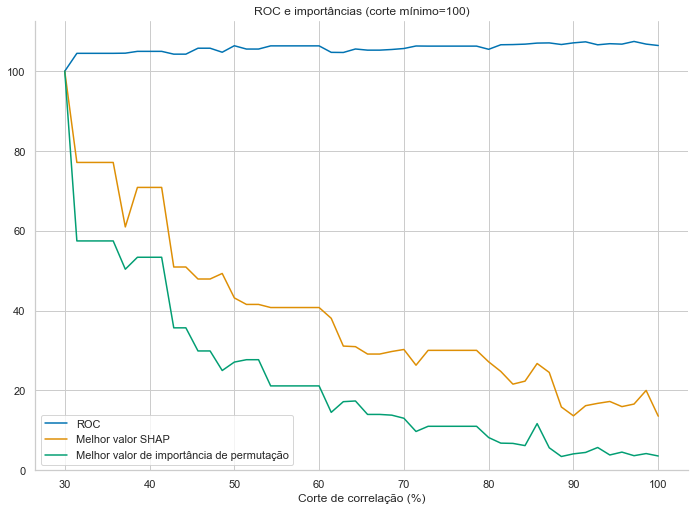

In [36]:
cols = ["roc", "best_shap", "best_imp"]
simulations_norm = (
    simulations[cols]
    .div(simulations.loc[simulations.index.min(), cols])
    .mul(100)
)
ax = (
    simulations_norm
    .rename(columns={
        "roc": "ROC",
        "best_shap": "Melhor valor SHAP",
        "best_imp": "Melhor valor de importância de permutação",
    })
    .plot.line()
)
ax.set(
    title="ROC e importâncias (corte mínimo=100)",
    xlabel="Corte de correlação (%)",
    ylim=[0, ax.get_ylim()[1]]
)
sns.despine()

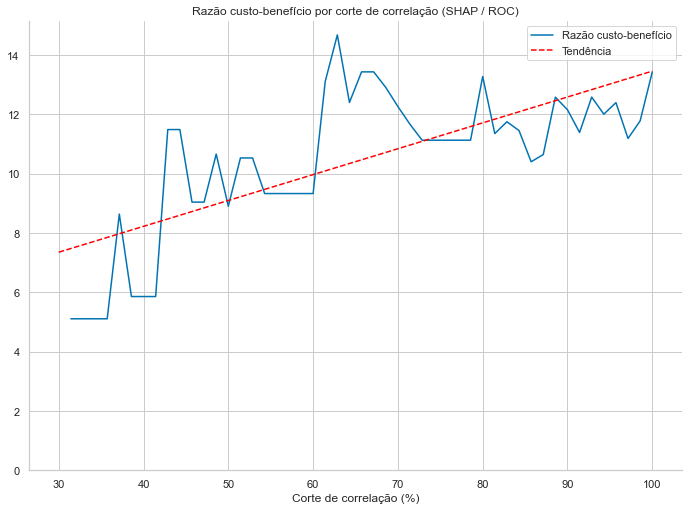

In [37]:
simulations_norm["cost_benefit"] = (
    simulations_norm["best_shap"].sub(100).abs()
    .div(simulations_norm["roc"].sub(100).abs())
)

trend_coefs = np.polyfit(
    simulations_norm.index.values.astype(float)[1:],
    simulations_norm["cost_benefit"].values.astype(float)[1:],
    deg=1
)
trend = np.poly1d(trend_coefs)

ax = (
    simulations_norm["cost_benefit"]
    .rename("Razão custo-benefício")
    .plot.line()
)
ax = pd.Series(
    trend(simulations_norm.index.values),
    name="Tendência",
    index=simulations_norm.index
).plot.line(ax=ax, color="red", style="--")
ax.set(
    title="Razão custo-benefício por corte de correlação (SHAP / ROC)", 
    xlabel="Corte de correlação (%)",
    ylim=[0, ax.get_ylim()[1]]
)
ax.legend()
sns.despine()

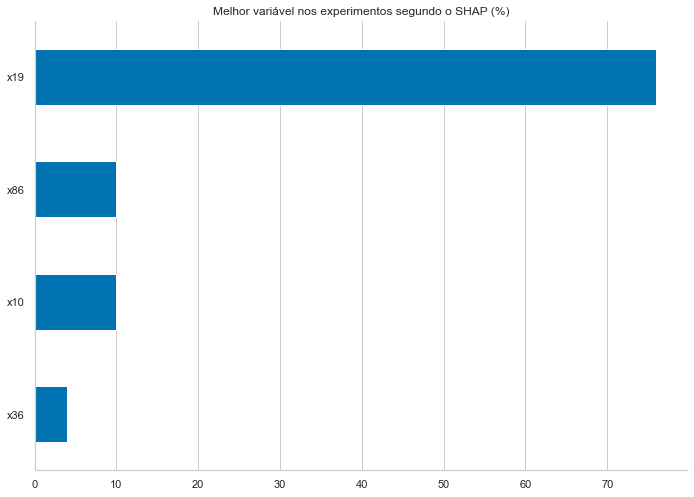

In [38]:
ax = (
    simulations["best_feature_shap"].value_counts(normalize=True)
    .mul(100)
    .sort_values()
    .plot.barh()
)
ax.set(title="Melhor variável nos experimentos segundo o SHAP (%)")
ax.grid(axis="y")
sns.despine()